In [1]:
import functools
import unittest
import math
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import quad, dblquad, tplquad
from scipy.special import sph_harm, jacobi

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

Here we define the Wigner small-d matrix and tests for it.

In [20]:
"""
The Wigner small-d matrix is defined as

    d_{m1, m2}^j(beta) = <j, m1|exp(-i beta J_y)|j, m2>

where J_y is the y-component of the angular momentum operator J. The matrix elements are
given by

    d_{m1, m2}^j(beta) = sqrt[(j + m2)!(j - m2)!(j + m1)!(j - m1)!] * sum_{s = max(0, m1 - m2)}^{min(j + m1, j - m2)} (-1)^{m2 - m1 + s} * cos(beta/2)^{2j + m1 - m2 - 2s} * sin(beta/2)^{m2 - m1 + 2s} / [(j + m1 - s)! s! (m2 - m1 + s)! (j - m2 - s)!]
"""


def _comb(n, k) -> int:
    return math.comb(int(n), int(k))


def wigner_small_d(*, j: float | int, m2: float | int, m1: float | int, beta: float | int) -> float:
    """
    Calculate the Wigner small-d matrix element d_{m1, m2}^j(beta).

    See: https://en.wikipedia.org/wiki/Wigner_D-matrix#Wigner_(small)_d-matrix

    Parameters
    ----------
    j : float | int
        The angular momentum quantum number.
    m2 : float | int
        The m2 quantum number.
    m1 : float | int
        The m1 quantum number.
    beta : float
        The angle beta.
    """

    # Check that the quantum numbers are valid
    if not all(isinstance(x, (float, int)) for x in (j, m2, m1)):
        raise ValueError("All quantum numbers must be floats or ints.")
    
    if not isinstance(beta, (float, int)):
        raise ValueError("The angle beta must be a float or int.")
    
    k = int(min(j + m1, j - m1, j + m2, j - m2))
    if k == int(j + m1) or k == int(j - m2):
        a = lmbda = int(m2 - m1)
    else:
        a = int(m1 - m2)
        lmbda = 0

    b = int(2 * j - 2 * k - a)

    return (
        (-1)**lmbda
        * math.sqrt(_comb(2 * j - k, k + a))
        * math.sqrt(_comb(k + b, b))**(-1)
        * math.sin(beta / 2)**a
        * math.cos(beta / 2)**b
        * jacobi(k, a, b)(math.cos(beta))
    )


In [6]:
"""
Unit tests for the Wigner small-d matrix.
"""

class TestWignerSmallD(unittest.TestCase):

    def test_wigner_small_d_returns_float(self):
        """
        Test that the Wigner small-d matrix element returns a float.
        """
        # Test some values
        subtests = [
            # j, m1, m2, beta
            # j = 0
            (0, 0, 0, 0),
            (0, 0, 0, 0.1),
            (0, 0, 0, 0.3),
            (0, 0, 0, 1),
            (0, 0, 0, 10),
            # j = 1
            (1, 1, 1, 0),
            (1, 1, 1, 0.1),
            (1, 1, 1, 0.3),
            (1, 1, 1, 1),
            (1, 1, 1, 10),
            (1, -1, 1, 0),
            (1, -1, 1, 0.1),
            (1, -1, 1, 0.3),
            (1, -1, 1, 1),
            (1, -1, 1, 10),
            (1, 0, 1, 0),
            (1, 0, 1, 0.1),
            (1, 0, 1, 0.3),
            (1, 0, 1, 1),
            (1, 0, 1, 10),
            # j = 1/2
            (1/2, 1/2, 1/2, 0),
            (1/2, 1/2, 1/2, 0.1),
            (1/2, 1/2, 1/2, 0.3),
            (1/2, 1/2, 1/2, 1),
            (1/2, 1/2, 1/2, 10),
            (1/2, -1/2, 1/2, 0),
            (1/2, -1/2, 1/2, 0.1),
            (1/2, -1/2, 1/2, 0.3),
            (1/2, -1/2, 1/2, 1),
            (1/2, -1/2, 1/2, 10),
            # j = 3
            (3, 3, 3, 0),
            (3, 3, 3, 0.1),
            (3, 3, 3, 0.3),
            (3, 3, 3, 1),
            (3, 3, 3, 10),
            (3, -3, 3, 0),
            (3, -3, 3, 0.1),
            (3, -3, 3, 0.3),
            (3, -3, 3, 1),
            (3, -3, 3, 10),
            (3, 0, 3, 0),
            (3, 0, 3, 0.1),
            (3, 0, 3, 0.3),
            (3, 0, 3, 1),
            (3, 0, 3, 10),
        ]

        for j, m1, m2, beta in subtests:
            with self.subTest(j=j, m1=m1, m2=m2, beta=beta):
                self.assertIsInstance(
                    wigner_small_d(j=j, m2=m2, m1=m1, beta=beta),
                    float
                )
    
    def test_wigner_small_d_returns_correct_values(self):
        """
        Test that the Wigner small-d matrix element returns the correct values.
        """
        # Test some values
        subtests = [
            # j, m1, m2, beta, expected
            # j = 0
            (0, 0, 0, 0, 1),
            (0, 0, 0, 0.1, 1),
            (0, 0, 0, 0.3, 1),
            (0, 0, 0, 1, 1),
            (0, 0, 0, 10, 1),
            # j = 1/2
            (1/2, 1/2, 1/2, 0.0, 1.0),
            (1/2, 1/2, 1/2, 0.1, 0.998750),
            (1/2, 1/2, 1/2, 0.2, 0.995004),
            (1/2, 1/2, 1/2, 0.3, 0.988771),
            (1/2, 1/2, 1/2, 0.4, 0.980067),
            (1/2, 1/2, 1/2, 0.5, 0.968912),
            (1/2, 1/2, 1/2, 0.6, 0.955336),
            (1/2, 1/2, 1/2, 0.7, 0.939373),
            (1/2, 1/2, 1/2, 0.8, 0.921061),
            (1/2, 1/2, 1/2, 0.9, 0.900447),
            (1/2, 1/2, 1/2, 1.0, 0.877583),
            (1/2, 1/2, 1/2, 1.1, 0.852525),
            (1/2, 1/2, 1/2, 1.2, 0.825336),
            (1/2, 1/2, 1/2, 1.3, 0.796084),
            (1/2, 1/2, 1/2, 1.4, 0.764842),
            (1/2, 1/2, 1/2, 1.5, 0.731689),
            (1/2, 1/2, 1/2, 1.6, 0.696707),
            (1/2, 1/2, 1/2, 1.7, 0.659983),
            (1/2, 1/2, 1/2, 1.8, 0.62161),
            (1/2, 1/2, 1/2, 1.9, 0.581683),
            (1/2, 1/2, 1/2, 2.0, 0.540302),
            (1/2, 1/2, 1/2, 2.1, 0.497571),
            (1/2, 1/2, 1/2, 2.2, 0.453596),
            (1/2, 1/2, 1/2, 2.3, 0.408487),
            (1/2, 1/2, 1/2, 2.4, 0.362358),
            (1/2, 1/2, 1/2, 2.5, 0.315322),
            (1/2, 1/2, 1/2, 2.6, 0.267499),
            (1/2, 1/2, 1/2, 2.7, 0.219007),
            (1/2, 1/2, 1/2, 2.8, 0.169967),
            (1/2, 1/2, 1/2, 2.9, 0.120503),
            (1/2, 1/2, 1/2, 3.0, 0.0707372),
            (1/2, 1/2, 1/2, 3.1, 0.0207948),
            (1/2, 1/2, 1/2, 3.2, -0.0291995),
            (1/2, 1/2, 1/2, 3.3, -0.0791209),
            (1/2, 1/2, 1/2, 3.4, -0.128844),
            (1/2, 1/2, 1/2, 3.5, -0.178246),
            (1/2, 1/2, 1/2, 3.6, -0.227202),
            (1/2, 1/2, 1/2, 3.7, -0.27559),
            (1/2, 1/2, 1/2, 3.8, -0.32329),
            (1/2, 1/2, 1/2, 3.9, -0.370181),
            (1/2, 1/2, 1/2, 4.0, -0.416147),
            (1/2, 1/2, 1/2, 4.1, -0.461073),
            (1/2, 1/2, 1/2, 4.2, -0.504846),
            (1/2, 1/2, 1/2, 4.3, -0.547358),
            (1/2, 1/2, 1/2, 4.4, -0.588501),
            (1/2, 1/2, 1/2, 4.5, -0.628174),
            (1/2, 1/2, 1/2, 4.6, -0.666276),
            (1/2, 1/2, 1/2, 4.7, -0.702713),
            (1/2, 1/2, 1/2, 4.8, -0.737394),
            (1/2, 1/2, 1/2, 4.9, -0.770231),
            (1/2, 1/2, 1/2, 5.0, -0.801144),
            (1/2, 1/2, 1/2, 5.1, -0.830054),
            (1/2, 1/2, 1/2, 5.2, -0.856889),
            (1/2, 1/2, 1/2, 5.3, -0.881582),
            (1/2, 1/2, 1/2, 5.4, -0.904072),
            (1/2, 1/2, 1/2, 5.5, -0.924302),
            (1/2, 1/2, 1/2, 5.6, -0.942222),
            (1/2, 1/2, 1/2, 5.7, -0.957787),
            (1/2, 1/2, 1/2, 5.8, -0.970958),
            (1/2, 1/2, 1/2, 5.9, -0.981702),
            (1/2, 1/2, 1/2, 6.0, -0.989992),
            (1/2, 1/2, 1/2, 6.1, -0.995808),
            (1/2, 1/2, 1/2, 6.2, -0.999135),
            (1/2, -1/2, 1/2, 0.0, 0),
            (1/2, -1/2, 1/2, 0.1, -0.0499792),
            (1/2, -1/2, 1/2, 0.2, -0.0998334),
            (1/2, -1/2, 1/2, 0.3, -0.149438),
            (1/2, -1/2, 1/2, 0.4, -0.198669),
            (1/2, -1/2, 1/2, 0.5, -0.247404),
            (1/2, -1/2, 1/2, 0.6, -0.29552),
            (1/2, -1/2, 1/2, 0.7, -0.342898),
            (1/2, -1/2, 1/2, 0.8, -0.389418),
            (1/2, -1/2, 1/2, 0.9, -0.434966),
            (1/2, -1/2, 1/2, 1.0, -0.479426),
            (1/2, -1/2, 1/2, 1.1, -0.522687),
            (1/2, -1/2, 1/2, 1.2, -0.564642),
            (1/2, -1/2, 1/2, 1.3, -0.605186),
            (1/2, -1/2, 1/2, 1.4, -0.644218),
            (1/2, -1/2, 1/2, 1.5, -0.681639),
            (1/2, -1/2, 1/2, 1.6, -0.717356),
            (1/2, -1/2, 1/2, 1.7, -0.75128),
            (1/2, -1/2, 1/2, 1.8, -0.783327),
            (1/2, -1/2, 1/2, 1.9, -0.813416),
            (1/2, -1/2, 1/2, 2.0, -0.841471),
            (1/2, -1/2, 1/2, 2.1, -0.867423),
            (1/2, -1/2, 1/2, 2.2, -0.891207),
            (1/2, -1/2, 1/2, 2.3, -0.912764),
            (1/2, -1/2, 1/2, 2.4, -0.932039),
            (1/2, -1/2, 1/2, 2.5, -0.948985),
            (1/2, -1/2, 1/2, 2.6, -0.963558),
            (1/2, -1/2, 1/2, 2.7, -0.975723),
            (1/2, -1/2, 1/2, 2.8, -0.98545),
            (1/2, -1/2, 1/2, 2.9, -0.992713),
            (1/2, -1/2, 1/2, 3.0, -0.997495),
            (1/2, -1/2, 1/2, 3.1, -0.999784),
            (1/2, -1/2, 1/2, 3.2, -0.999574),
            (1/2, -1/2, 1/2, 3.3, -0.996865),
            (1/2, -1/2, 1/2, 3.4, -0.991665),
            (1/2, -1/2, 1/2, 3.5, -0.983986),
            (1/2, -1/2, 1/2, 3.6, -0.973848),
            (1/2, -1/2, 1/2, 3.7, -0.961275),
            (1/2, -1/2, 1/2, 3.8, -0.9463),
            (1/2, -1/2, 1/2, 3.9, -0.92896),
            (1/2, -1/2, 1/2, 4.0, -0.909297),
            (1/2, -1/2, 1/2, 4.1, -0.887362),
            (1/2, -1/2, 1/2, 4.2, -0.863209),
            (1/2, -1/2, 1/2, 4.3, -0.836899),
            (1/2, -1/2, 1/2, 4.4, -0.808496),
            (1/2, -1/2, 1/2, 4.5, -0.778073),
            (1/2, -1/2, 1/2, 4.6, -0.745705),
            (1/2, -1/2, 1/2, 4.7, -0.711473),
            (1/2, -1/2, 1/2, 4.8, -0.675463),
            (1/2, -1/2, 1/2, 4.9, -0.637765),
            (1/2, -1/2, 1/2, 5.0, -0.598472),
            (1/2, -1/2, 1/2, 5.1, -0.557684),
            (1/2, -1/2, 1/2, 5.2, -0.515501),
            (1/2, -1/2, 1/2, 5.3, -0.472031),
            (1/2, -1/2, 1/2, 5.4, -0.42738),
            (1/2, -1/2, 1/2, 5.5, -0.381661),
            (1/2, -1/2, 1/2, 5.6, -0.334988),
            (1/2, -1/2, 1/2, 5.7, -0.287478),
            (1/2, -1/2, 1/2, 5.8, -0.239249),
            (1/2, -1/2, 1/2, 5.9, -0.190423),
            (1/2, -1/2, 1/2, 6.0, -0.14112),
            (1/2, -1/2, 1/2, 6.1, -0.0914646),
            (1/2, -1/2, 1/2, 6.2, -0.0415807),
            # j = 1
            (1, 1, 1, 0, 1),
            (1, 1, 1, 0.1, 0.997502),
            (1, 1, 1, 0.3, 0.977668),
            (1, 1, 1, 1, 0.770151),
            (1, 1, 1, 10, 0.0804642),
            (1, -1, 1, 0, 0),
            (1, -1, 1, 0.1, 0.00249792),
            (1, -1, 1, 0.3, 0.0223318),
            (1, -1, 1, 1, 0.229849),
            (1, -1, 1, 10, 0.919536),
            (1, 0, 1, 0, 0),
            (1, 0, 1, 0.1, -0.0705929),
            (1, 0, 1, 0.3, -0.208964),
            (1, 0, 1, 1, -0.59501),
            (1, 0, 1, 10, 0.384681),
            # j = 3
            (3, 3, 3, 0, 1),
            (3, 3, 3, 0.1, 0.992525),
            (3, 3, 3, 0.3, 0.93449),
            (3, 3, 3, 1, 0.456802),
            (3, 3, 3, 10, 0.000520965),
            (3, -3, 3, 0, 0),
            (3, -3, 3, 0.1, 1.5586e-8),
            (3, -3, 3, 0.3, 0.000011137),
            (3, -3, 3, 1, 0.012143),
            (3, -3, 3, 10, 0.77751),
            (3, 0, 3, 0, 0),
            (3, 0, 3, 0.1, -0.000556228),
            (3, 0, 3, 0.3, -0.0144273),
            (3, 0, 3, 1, -0.333075),
            (3, 0, 3, 10, 0.0900062),
        ]

        for j, m1, m2, beta, expected in subtests:
            with self.subTest(j=j, m1=m1, m2=m2, beta=beta):
                self.assertAlmostEqual(
                    wigner_small_d(j=j, m2=m2, m1=m1, beta=beta),
                    expected,
                    places=5
                )

    @unittest.skip("This test is too slow.")
    def test_wigner_small_d_orthogonality(self):
        """
        See: https://en.wikipedia.org/wiki/Wigner_D-matrix#Orthogonality_relations
        """

        subtets = [
            # (j1, m1, k1, j2, m2, k2, expected)
            # -j1 <= m1, k1 <= j1 and -j2 <= m2, k2 <= j2 
            # j1, j2 = 0, 0
            (0, 0, 0, 0, 0, 0, 1),
            # j1, j2, = 0, 1
            (0, 0, 0, 1, 0, 0, 0),
            (0, 0, 0, 1, 0, 1, 0),
            (0, 0, 0, 1, 1, 0, 0),
            (0, 0, 0, 1, 1, 1, 0),
            # j1, j2 = 1, 1
            (1, 0, 0, 1, 0, 0, 1),
            (1, 0, 0, 1, 0, 1, 0),
            (1, 0, 0, 1, 1, 0, 0),
            (1, 0, 0, 1, 1, 1, 0),
            (1, 0, 1, 1, 0, 0, 0),
            (1, 0, 1, 1, 0, 1, 1),
            (1, 0, 1, 1, 1, 0, 0),
            (1, 0, 1, 1, 1, 1, 0),
            (1, 1, 0, 1, 0, 0, 0),
            (1, 1, 0, 1, 0, 1, 0),
            (1, 1, 0, 1, 1, 0, 1),
            (1, 1, 0, 1, 1, 1, 0),
            (1, 1, 1, 1, 0, 0, 0),
            (1, 1, 1, 1, 0, 1, 0),
            (1, 1, 1, 1, 1, 0, 0),
            (1, 1, 1, 1, 1, 1, 1),
            # j1, j2 = 1/2, 1
            (1/2, -1/2, 1/2, 1, 0, 0, 0),
            (1/2, -1/2, 1/2, 1, 0, 1, 0),
            (1/2, -1/2, 1/2, 1, 1, 0, 0),
            (1/2, -1/2, 1/2, 1, 1, 1, 0),
            (1/2, 1/2, 1/2, 1, 0, 0, 0),
            (1/2, 1/2, 1/2, 1, 0, 1, 0),
            (1/2, 1/2, 1/2, 1, 1, 0, 0),
            (1/2, 1/2, 1/2, 1, 1, 1, 0),
            # j1, j2 = 1, 3
            (1, 0, 0, 3, 0, 0, 0),
            (1, 0, 0, 3, 0, 1, 0),
            (1, 0, 0, 3, 1, 0, 0),
            (1, 0, 0, 3, 1, 1, 0),
            (1, 0, 1, 3, 0, 0, 0),
            (1, 0, 1, 3, 0, 1, 0),
            (1, 0, 1, 3, 1, 0, 0),
            (1, 0, 1, 3, 1, 1, 0),
            (1, 1, 0, 3, 0, 0, 0),
            (1, 1, 0, 3, 0, 1, 0),
            (1, 1, 0, 3, 1, 0, 0),
            (1, 1, 0, 3, 1, 1, 0),
            (1, 1, 1, 3, 0, 0, 0),
            (1, 1, 1, 3, 0, 1, 0),
            (1, 1, 1, 3, 1, 0, 0),
            (1, 1, 1, 3, 1, 1, 0),
            # j1, j2 = 3, 3
            (3, 0, 0, 3, 0, 0, 1),
            (3, 0, 0, 3, 0, 1, 0),
            (3, 0, 0, 3, 1, 0, 0),
            (3, 0, 0, 3, 1, 1, 0),
            (3, 0, 0, 3, 2, 0, 0),
            (3, 0, 0, 3, 2, 1, 0),
            (3, 0, 0, 3, 3, 0, 0),
            (3, 0, 0, 3, 3, 1, 0),
            (3, 0, 0, 3, 3, 2, 0),
            (3, 0, 0, 3, 3, 3, 0),
        ]

        for j1, m1, k1, j2, m2, k2, expected in subtets:
            with self.subTest(j1=j1, j2=j2, m1=m1, m2=m2, k1=k1, k2=k2):
                result = tplquad(
                    lambda gamma, beta, alpha, : (
                          (2 * j1 + 1) / (32 * np.pi**2)
                        * np.exp(1j * (m2 - m1) * alpha)
                        * np.exp(1j * (k2 - k1) * gamma)
                        * wigner_small_d(j=j1, m2=m1, m1=k1, beta=beta)
                        * wigner_small_d(j=j2, m2=m2, m1=k2, beta=beta)
                        * math.sin(beta)
                    ),
                    0, 4 * np.pi,
                    lambda x: 0, np.pi,
                    lambda x, y: 0, 4 * np.pi,
                    epsabs=1e-5,
                )[0]
                self.assertAlmostEqual(result, expected, places=5)


def suite():
    suite = unittest.TestSuite()
    suite.addTest(TestWignerSmallD("test_wigner_small_d_returns_float"))
    suite.addTest(TestWignerSmallD("test_wigner_small_d_returns_correct_values"))
    suite.addTest(TestWignerSmallD("test_wigner_small_d_orthogonality"))
    return suite

runner = unittest.TextTestRunner()
runner.run(suite())

../home/alex/Mestrado/Numerics/aniso/.venv/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:611: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
.
----------------------------------------------------------------------
Ran 3 tests in 1012.619s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

In [21]:
"""
Sphereical harmonics and h functions
"""

def y3_alpha(*, m: int):
    """
    Calculate the spherical harmonic Y_{3, m} rotated by an angle alpha
    around the y-axis.

    Parameters
    ----------
    m : int
        The m quantum number.
    """
    
    def _y_rotated(alpha: float, theta: float, phi: float) -> complex:
        return sum(
            sph_harm(n, 3, phi, theta) * wigner_small_d(j=3, m2=n, m1=m, beta=alpha)
            for n in range(-m, m + 1, 1)
        )
    return _y_rotated


def h(alpha: float, theta: float, phi: float, *, s: int):
    """
    Calculate the h function for a given angle alpha.

    Parameters
    ----------
    alpha : float
        The angle alpha.
    theta : float
        The polar angle.
    phi : float
        The azimuthal angle.
    s : +1 | -1
        The spin projection.
    """
    assert s in (+1, -1), "The spin projection must be +1 or -1."

    if s == +1:
        m = 1
        clebsh_gordan = 2/7
    elif s == -1:
        m = 2
        clebsh_gordan = 5/7
    
    return clebsh_gordan * y3_alpha(m=m)(alpha, theta, phi) * (
        1/7 * y3_alpha(m=2)(alpha, theta, phi) 
        + 6/7 * y3_alpha(m=3)(alpha, theta, phi)
    )
    

def integrand_I(z: float, z0: float, alpha: float, theta: float, phi: float) -> complex:
    """Integrand of the I integral."""
    assert z0 < 1, "z0 must be less than 1."

    return 3/(8 * np.pi) * np.sin(theta) * np.cos(theta)**2 * sum(
        1 / (1 - h(alpha, theta, phi, s=s) * np.log(z0) * z)
        for s in (-1, 1)
    )


def I(z: float, z0: float, alpha: float):
    return dblquad(
        # In scipy the order of the variables is reversed: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.dblquad.html#scipy.integrate.dblquad
        lambda phi, theta: integrand_I(z, z0, alpha, theta, phi),
        0, np.pi,
        0, 2 * np.pi,
    )[0]


def A(z, z0, alpha):
    return 1 - I(z, z0, alpha) / I(z, z0, 0)


In [11]:
class TesteI(unittest.TestCase):
    def test_I_of_zero(self):
        self.assertAlmostEqual(I(0, 1e-1, 0), 1.0, places=5)
        self.assertAlmostEqual(I(0, 1e-1, np.pi / 2), 1.0, places=5)
        self.assertAlmostEqual(I(0, 1e-2, 0), 1.0, places=5)
        self.assertAlmostEqual(I(0, 1e-2, np.pi / 2), 1.0, places=5)

unittest.main(argv=['first-arg-is-ignored'], exit=False)

../home/alex/Mestrado/Numerics/aniso/.venv/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:611: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
.
----------------------------------------------------------------------
Ran 3 tests in 10.438s

OK


# Cálculos

In [23]:
"""
Plot de I(z, z0, alpha) em função de z
alpha = 0, pi/6, pi/3, pi/2
z0 = 1e-2
"""

z0 = 1e-2
zs = np.arange(0, 100, 0.1) # will take around 7 days to run

Ix = np.array([I(z, z0, np.pi / 2) for z in zs])
I1 = np.array([I(z, z0, np.pi / 3) for z in zs])
I2 = np.array([I(z, z0, np.pi / 6) for z in zs])
Iz = np.array([I(z, z0, 0) for z in zs])

fig, ax = plt.subplots()
ax.set_title(r'Integral $I$ em função da razão ${\tau_{imp}}/{\tau_{inel}}$ $(x_0 = 10^{-2})$')
ax.plot(zs, Ix, label=r'$\alpha={\pi}/{2}$')
ax.plot(zs, I1, label=r'$\alpha={\pi}/{3}$')
ax.plot(zs, I2, label=r'$\alpha={\pi}/{6}$')
ax.plot(zs, Iz, label=r'$\alpha=0$')
ax.legend(loc='upper right')
ax.set_xlabel(r'$z = {\tau_{imp}}/{\tau_{inel}}$ [adimensional]')
ax.set_ylabel(r'$I(z, \alpha; x_0)$ [adimensional]')
plt.savefig('I_z__5_2.png')

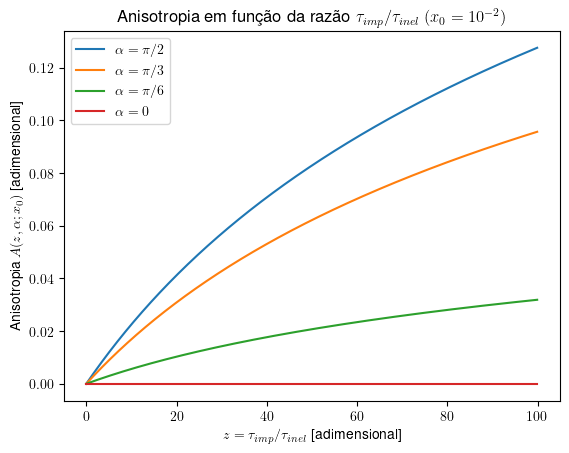

In [4]:
"""
Plot de A(z, z0, alpha) em função de z
alpha = 0, pi/6, pi/3, pi/2
x0 = 1e-2
"""

z0 = 1e-2
zs = np.arange(0, 100, 0.1)

Ax = np.array([A(z, z0, np.pi / 2) for z in zs])
A1 = np.array([A(z, z0, np.pi / 3) for z in zs])
A2 = np.array([A(z, z0, np.pi / 6) for z in zs])
Az = np.array([A(z, z0, 0) for z in zs])

fig, ax = plt.subplots()
ax.set_title(r'Anisotropia em função da razão ${\tau_{imp}}/{\tau_{inel}}$ $(x_0 = 10^{-2})$')
ax.plot(zs, Ax, label=r'$\alpha={\pi}/{2}$')
ax.plot(zs, A1, label=r'$\alpha={\pi}/{3}$')
ax.plot(zs, A2, label=r'$\alpha={\pi}/{6}$')
ax.plot(zs, Az, label=r'$\alpha=0$')
ax.legend(loc='upper left')
ax.set_xlabel(r'$z = {\tau_{imp}}/{\tau_{inel}}$ [adimensional]')
ax.set_ylabel(r'Anisotropia $A(z, \alpha; x_0)$ [adimensional]')
plt.savefig('A_z__5_2.png')

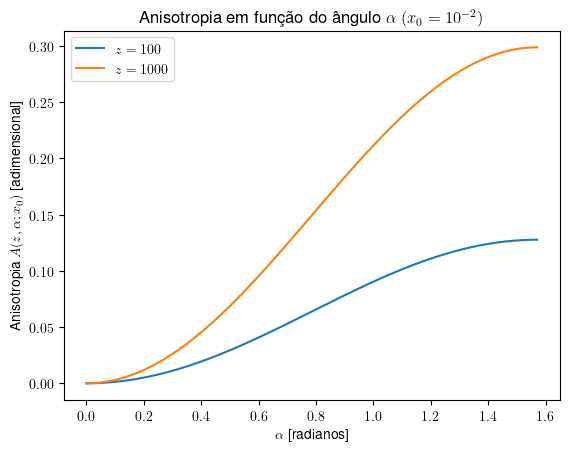

In [3]:
"""
Plot de A(z, z0, alpha) em função de \alpha
z = 100
x0 = 1e-2
"""

z0 = 1e-2
alphas = np.arange(0, np.pi / 2, 0.01)

A100 = np.array([A(100, z0, a) for a in alphas])
A1000 = np.array([A(1000, z0, a) for a in alphas])

fig, ax = plt.subplots()
ax.set_title(r'Anisotropia em função do ângulo $\alpha$ $(x_0 = 10^{-2})$')
ax.plot(alphas, A100, label=r'$z=100$')
ax.plot(alphas, A1000, label=r'$z=1000$')
ax.legend(loc='upper left')
ax.set_xlabel(r'$\alpha$ [radianos]')
ax.set_ylabel(r'Anisotropia $A(z, \alpha; x_0)$ [adimensional]')
plt.savefig('A_alphas__5_2.png')